# Researching & Developing a Market Neutral Strategy
The process involves the following steps:

- Researching [partner data](https://www.quantopian.com/data).
- Designing a [pipeline](https://www.quantopian.com/tutorials/pipeline).
- Analyzing an alpha factor with [Alphalens](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors).
- Implementing our factor in the [IDE](https://www.quantopian.com/algorithms) (see backtest in next comment).
- Evaluating the backtest using [Pyfolio](https://www.quantopian.com/posts/new-feature-comprehensive-backtest-analysis).

## Part 1 - Investigate the Data with Blaze
To start out, let's investigate a partner dataset using [Blaze](http://blaze.pydata.org/). Blaze allows you to define expressions for selecting and transforming data without loading all of the data into memory. This makes it a nice tool for interacting with large amounts of data in research.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# http://blaze.readthedocs.io/en/latest/index.html
import blaze as bz

from zipline.utils.tradingcalendar import get_trading_days

from quantopian.interactive.data.sentdex import sentiment

Interactive datasets are [Blaze expressions](http://blaze.readthedocs.io/en/latest/interactivity.html). Blaze expressions have a similar API to pandas, with some [differences](http://blaze.readthedocs.io/en/latest/rosetta-pandas.html).

In [2]:
type(sentiment)

<class 'blaze.expr.expressions.Field'>

Let's start by looking at a sample of the data in the [Sentdex Sentiment Analysis](https://www.quantopian.com/data/sentdex/sentiment) dataset for AAPL.

In [3]:
aapl_sid = symbols('AAPL').sid

# Look at a sample of AAPL sentiment data starting from 2013-12-01.
sentiment[(sentiment.sid == aapl_sid) & (sentiment.asof_date >= '2013-12-01')].peek()

,symbol,sentiment_signal,sid,asof_date,timestamp
0,AAPL,1.0,24,2013-12-01,2013-12-02
1,AAPL,6.0,24,2013-12-02,2013-12-03
2,AAPL,5.0,24,2013-12-03,2013-12-04
3,AAPL,6.0,24,2013-12-04,2013-12-05
4,AAPL,4.0,24,2013-12-05,2013-12-06
5,AAPL,2.0,24,2013-12-06,2013-12-07
6,AAPL,-1.0,24,2013-12-07,2013-12-08
7,AAPL,-1.0,24,2013-12-08,2013-12-09
8,AAPL,-3.0,24,2013-12-09,2013-12-10
9,AAPL,-1.0,24,2013-12-10,2013-12-11


Let's see how many securities are covered by this dataset between 12/2013 and 12/2014.

In [4]:
num_sids = bz.compute(sentiment.sid.distinct().count())
print 'Number of sids in the data: %d' % num_sids

Number of sids in the data: 586


Let's go back to AAPL and let's look at the sentiment signal each day. To do this, we can create a Blaze expression that selects trading days and another for the AAPL `sid` (24).

In [5]:
# Mask for trading days.
date_mask = sentiment.asof_date.isin(
    get_trading_days(pd.Timestamp('2013-12-01'), pd.Timestamp('2014-12-01'))
)

# Mask for AAPL.
stock_mask = (sentiment.sid == aapl_sid)

# Blaze expression for AAPL sentiment on trading days between 12/2013 and 12/2014
sentiment_2014_expr = sentiment[date_mask & stock_mask].sort('asof_date')

Compute the expression. This returns the result in a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [6]:
sentiment_2014_df = bz.compute(sentiment_2014_expr)

Plot the sentiment signal for AAPL.

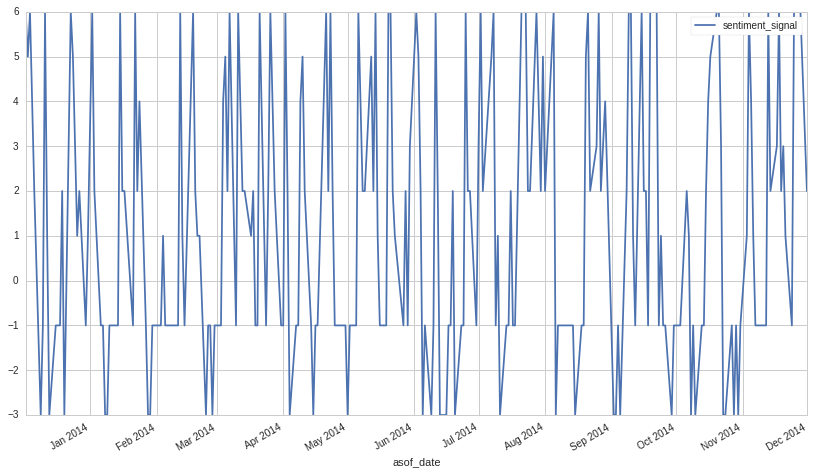

In [7]:
sentiment_2014_df.plot(x='asof_date', y='sentiment_signal')

The sentiment signal tends to jump quite a bit. Let's try smoothing it by plotting the 5-day mean using the [pandas.rolling_mean](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html) function. Note that we set the index of the Dataframe to be the `asof_date` so that the x-axis would be nicely formatted.

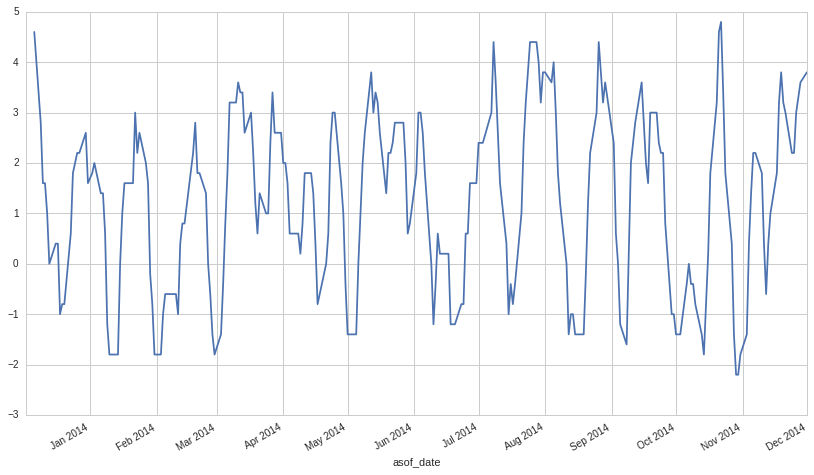

In [8]:
pd.rolling_mean(sentiment_2014_df.set_index('asof_date').sentiment_signal, window=5).plot()

Great! Now let's use this data in a pipeline.

## Part 2 - Define Our Factor
Now that we have a dataset that we want to use, let's use it in a [pipeline](https://www.quantopian.com/tutorials/pipeline). In addition to the sentiment dataset, we will also use the [EventVestor Earnings Calendar](https://www.quantopian.com/data/eventvestor/earnings_calendar) dataset to [avoid trading around earnings announcements](https://www.quantopian.com/posts/event-study-the-rising-impact-of-earnings-on-stock-returns), and the [EventVestor Mergers & Acquisitions](https://www.quantopian.com/data/eventvestor/mergers_and_acquisitions) dataset to avoid trading acquisition targets. We will work with the free versions of these datasets.

In [5]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters.morningstar import Q1500US

# Sentdex Sentiment free from 15 Oct 2012 to 1 month ago.
from quantopian.pipeline.data.sentdex import sentiment

# EventVestor Earnings Calendar free from 01 Feb 2007 to 1 year ago.
from quantopian.pipeline.factors.eventvestor import (
    BusinessDaysUntilNextEarnings,
    BusinessDaysSincePreviousEarnings,
)

# EventVestor Mergers & Acquisitions free from 01 Feb 2007 to 1 year ago.
from quantopian.pipeline.filters.eventvestor import IsAnnouncedAcqTarget

from quantopian.pipeline.factors import BusinessDaysSincePreviousEvent

In [6]:
def make_pipeline():
    
    # 5-day sentiment moving average factor.
    sentiment_factor = SimpleMovingAverage(inputs=[sentiment.sentiment_signal], window_length=5)
    
    # Filter for stocks that are not within 2 days of an earnings announcement.
    not_near_earnings_announcement = ~((BusinessDaysUntilNextEarnings() <= 2)
                                | (BusinessDaysSincePreviousEarnings() <= 2))
    
    # Filter for stocks that are announced acquisition target.
    not_announced_acq_target = ~IsAnnouncedAcqTarget()
    
    # Filter for stocks that had their sentiment signal updated in the last day.
    new_info = (BusinessDaysSincePreviousEvent(inputs=[sentiment.asof_date.latest]) <= 1)
    
    # Our universe is made up of stocks that have a non-null sentiment signal that was updated in
    # the last day, are not within 2 days of an earnings announcement, are not announced acquisition
    # targets, and are in the Q1500US.
    universe = (Q1500US() 
                & sentiment_factor.notnull() 
                & not_near_earnings_announcement
                & not_announced_acq_target
                & new_info)
    
    # Our pipeline is defined to have the rank of the sentiment_factor as the only column. It is
    # screened by our universe filter.
    pipe = Pipeline(
        columns={
            'sentiment': sentiment_factor.rank(mask=universe, method='average'),
        },
        screen=universe
    )
    
    return pipe

In [7]:
result = run_pipeline(make_pipeline(), start_date='2013-12-01', end_date='2014-12-01')

## Part 3 - Analyze Our Factor Using Alphalens
Now we can analyze our `sentiment` factor with Alphalens. To do this, we need to get pricing data using `get_pricing`.

In [8]:
# All assets that were returned in the pipeline result.
assets = result.index.levels[1].unique()

# We need to get a little more pricing data than the length of our factor so we 
# can compare forward returns. We'll tack on another month in this example.
pricing = get_pricing(assets, start_date='2013-12-01', end_date='2015-01-01', fields='open_price')

Then we run a factor tearsheet on our factor. We will analyze 3 quantiles, looking at 1, 5, and 10-day lookahead periods.

Returns Analysis


,1,5,10
Ann. alpha,0.019,0.005,-0.002
beta,-0.017,-0.028,-0.027
Mean Period Wise Return Top Quantile (bps),1.407,0.238,-0.125
Mean Period Wise Return Bottom Quantile (bps),-1.000,-0.552,-0.181
Mean Period Wise Spread (bps),2.291,0.690,-0.080


Information Analysis


,1,5,10
IC Mean,0.005,0.002,-0.005
IC Std.,0.051,0.055,0.058
t-stat(IC),1.503,0.574,-1.343
p-value(IC),0.134,0.567,0.181
IC Skew,-0.021,-0.107,-0.398
IC Kurtosis,0.294,-0.051,0.386
Ann. IR,1.503,0.574,-1.343


Turnover Analysis


,1
Quantile 1 Mean Turnover,0.056
Quantile 2 Mean Turnover,0.145
Quantile 3 Mean Turnover,0.085


,1
Mean Factor Rank Autocorrelation,0.982


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:2790: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


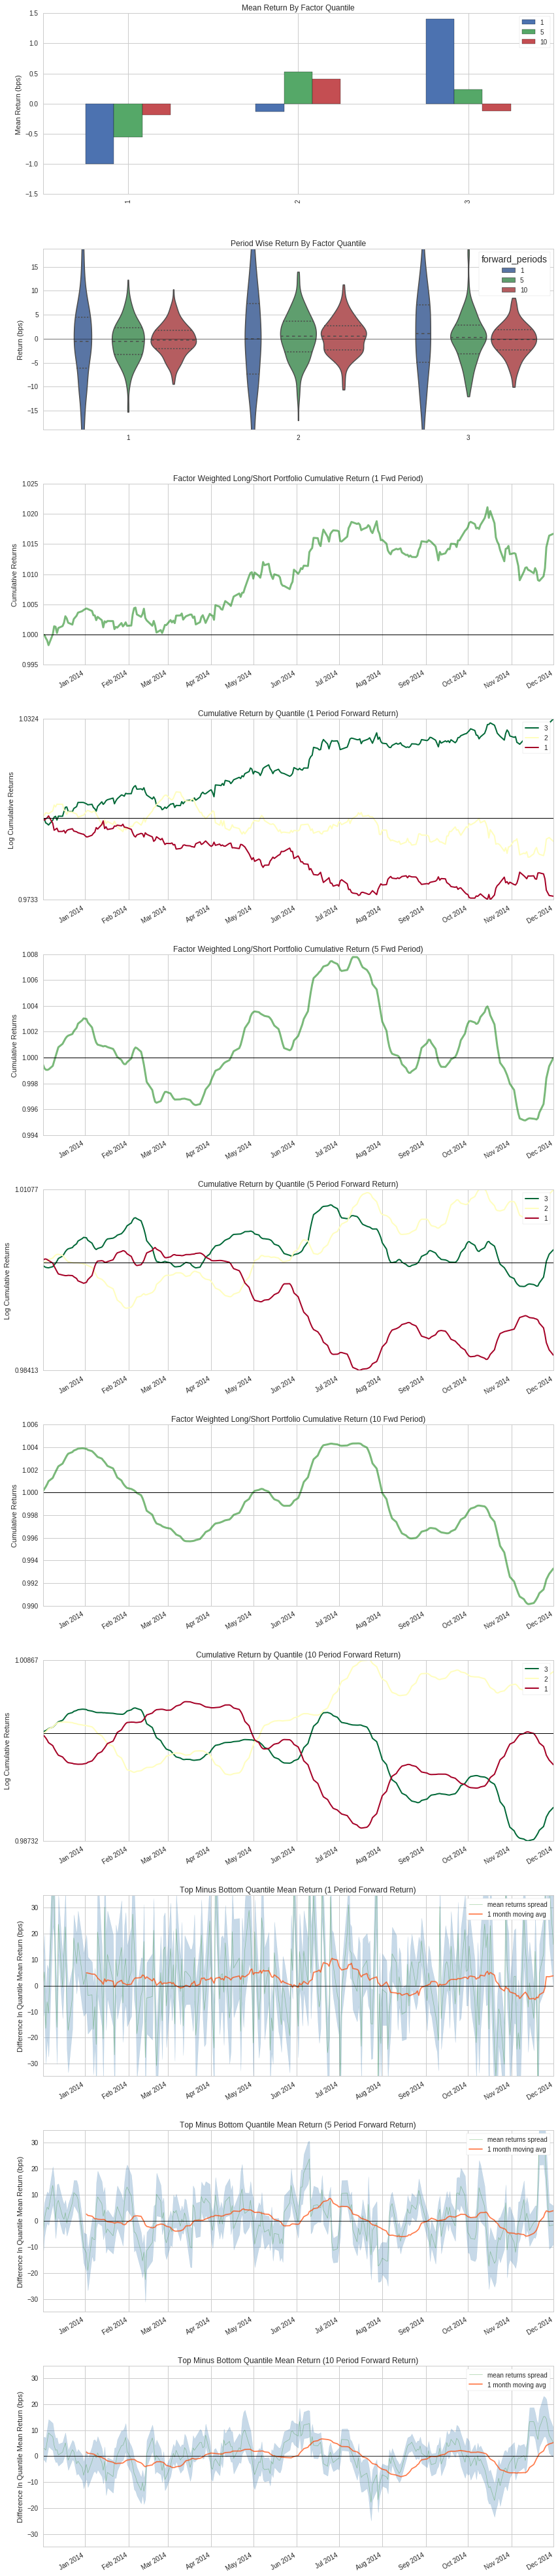

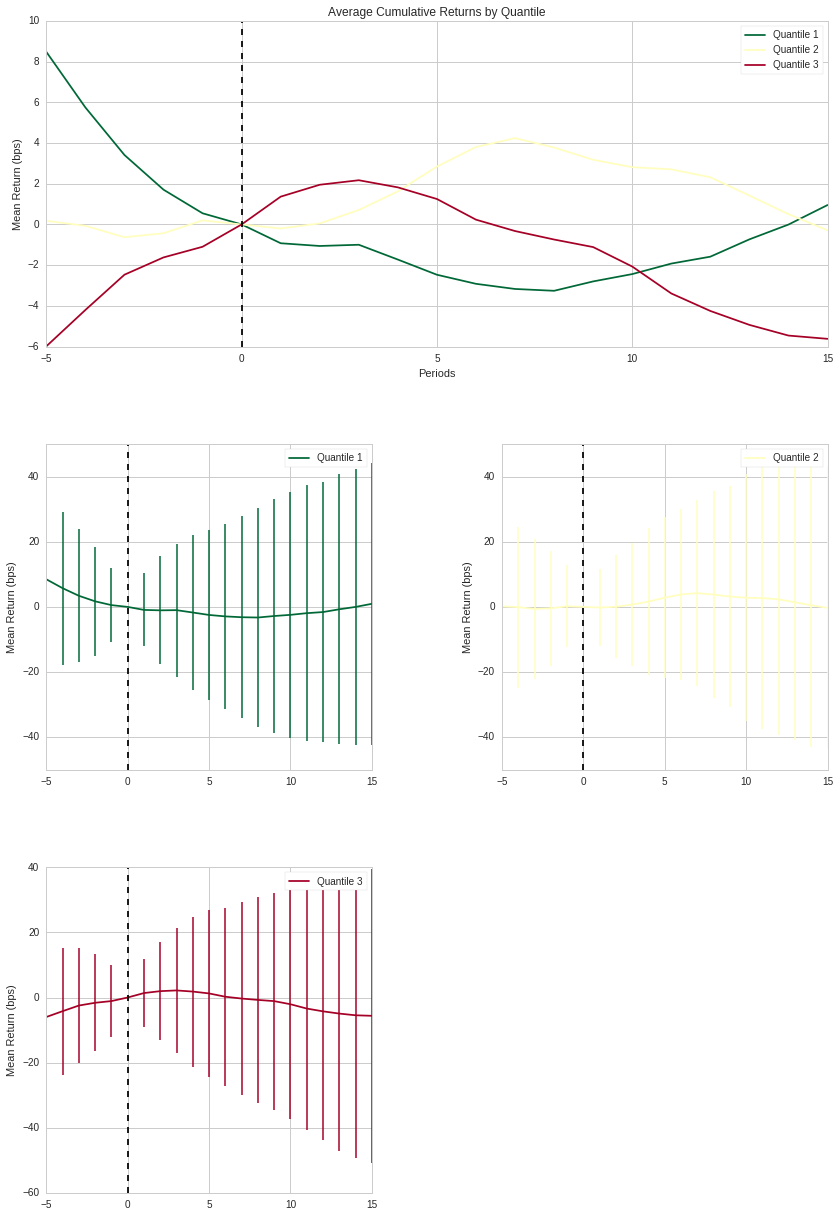

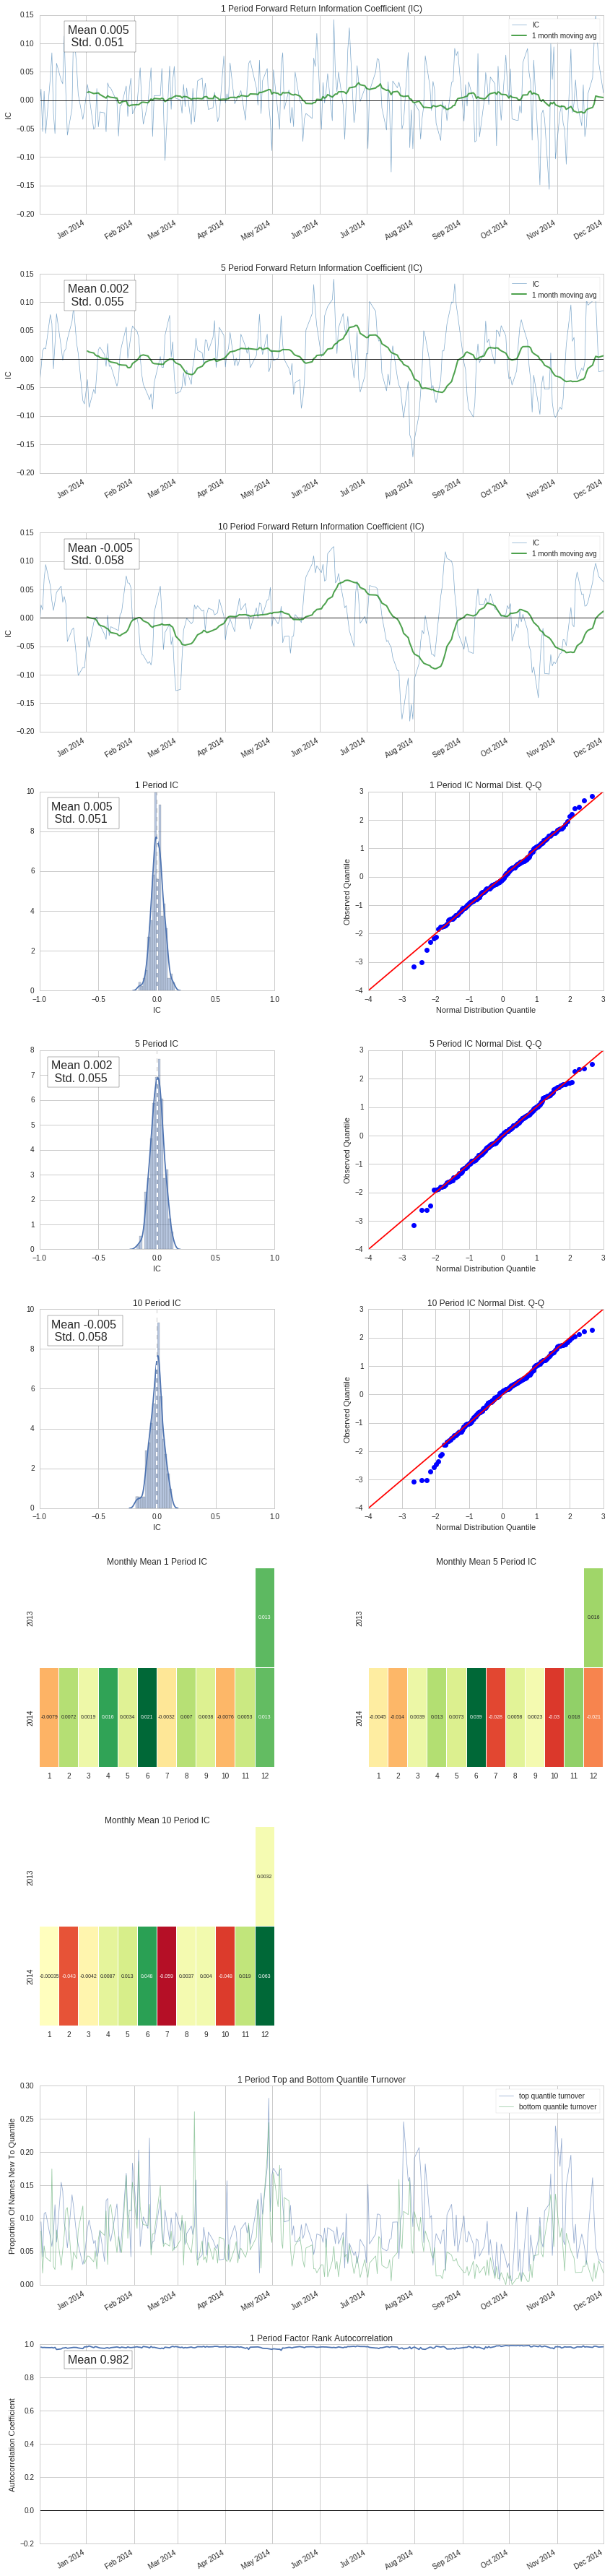

In [9]:
import alphalens

alphalens.tears.create_factor_tear_sheet(factor=result['sentiment'],
                                         prices=pricing,
                                         quantiles=3,
                                         periods=(1,5,10))

From this it looks like there's a relationship between the top quantile of our factor and positive returns as well as the bottom quantile and negative returns. 

Let's try to capitalize on this by implementing a strategy that opens long positions in the top quantile of stocks and short positions in the bottom quantile of stocks. Let's invest half of our portfolio and half short, and equally weight our positions in each direction.

Before moving to the IDE, let's make some small changes to the pipeline we defined earlier. This will make it easier to order stocks based on quantile.

In [10]:
def make_pipeline():
    
    # 5-day sentiment moving average factor.
    sentiment_factor = SimpleMovingAverage(inputs=[sentiment.sentiment_signal], window_length=5)
    
     # Filter for stocks that are not within 2 days of an earnings announcement.
    not_near_earnings_announcement = ~((BusinessDaysUntilNextEarnings() <= 2)
                                | (BusinessDaysSincePreviousEarnings() <= 2))
    
    # Filter for stocks that are announced acquisition target.
    not_announced_acq_target = ~IsAnnouncedAcqTarget()
    
    # Filter for stocks that had their sentiment signal updated in the last day.
    new_info = (BusinessDaysSincePreviousEvent(inputs=[sentiment.asof_date.latest]) <= 1)
    
    # Our universe is made up of stocks that have a non-null sentiment signal that was updated in
    # the last day, are not within 2 days of an earnings announcement, are not announced acquisition
    # targets, and are in the Q1500US.
    universe = (Q1500US() 
                & sentiment_factor.notnull() 
                & not_near_earnings_announcement
                & not_announced_acq_target
                & new_info)
    
    ### Now we are using a classifier to separate the stocks into quantiles based on sentiment
    ### rank.
    sentiment_quantiles = sentiment_factor.rank(mask=universe, method='average').quantiles(3)
    
    ### In our algorithm, we will go short the stocks in the 0th quantile, and long the stocks
    ### in the 2nd quantile.
    pipe = Pipeline(
        columns={
            'sentiment': sentiment_quantiles,
            'shorts': sentiment_quantiles.eq(0),
            'longs': sentiment_quantiles.eq(2),
        },
        screen=universe
    )
    
    return pipe

## Part 4 - Implement and Backtest the Strategy in the IDE.

See following post for the backtest.

## Part 5 - Analyze Our Backtest Using Pyfolio
Let's load our backtest result and run it through a tearsheet using pyfolio.

In [11]:
bt = get_backtest('58812b2977ca4c474bbf393f')

100% Time: 0:00:08|###########################################################|


Entire data start date: 2013-12-02
Entire data end date: 2014-12-01


Backtest Months: 12


Performance statistics,Backtest
annual_return,0.02
annual_volatility,0.01
sharpe_ratio,1.30
calmar_ratio,1.51
stability_of_timeseries,0.69
max_drawdown,-0.01
omega_ratio,1.23
sortino_ratio,1.89
skew,-0.15
kurtosis,0.55


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,1.14,2014-07-16,2014-11-21,NaT,NaN
1,0.57,2014-02-06,2014-02-24,2014-04-07,43
2,0.48,2014-05-02,2014-05-27,2014-06-10,28
3,0.34,2014-01-03,2014-01-09,2014-01-21,13
4,0.23,2014-06-20,2014-06-24,2014-06-30,7




[-0.002 -0.004]


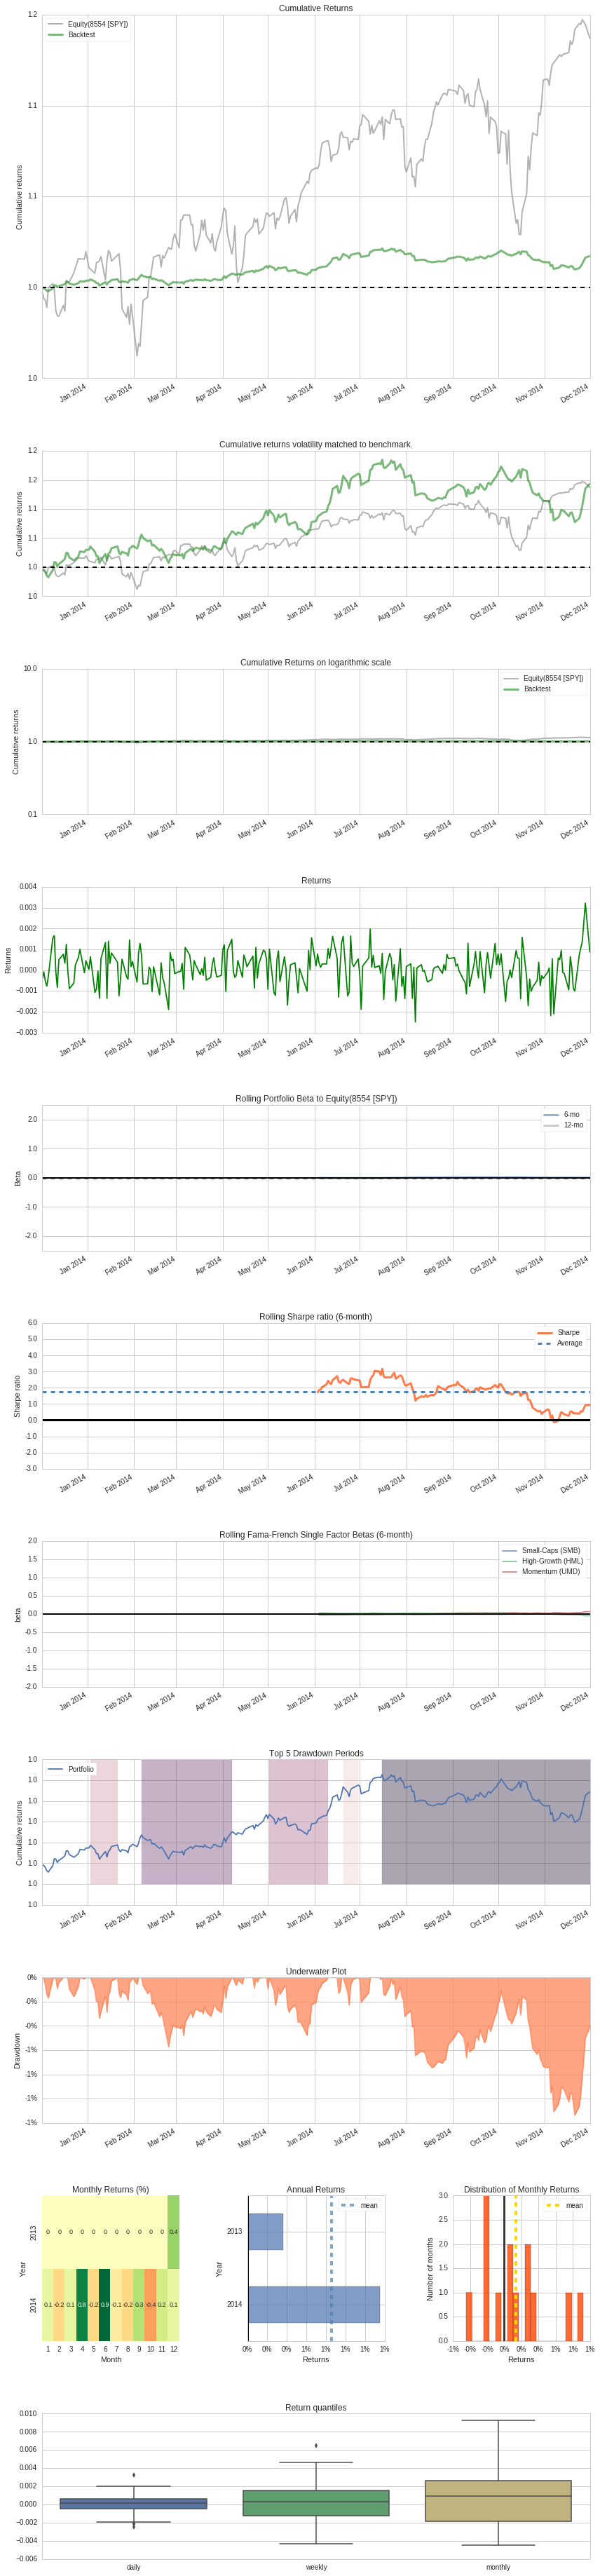

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Apr14,0.03%,-0.10%,0.15%
Oct14,-0.02%,-0.17%,0.16%
New Normal,0.01%,-0.25%,0.32%


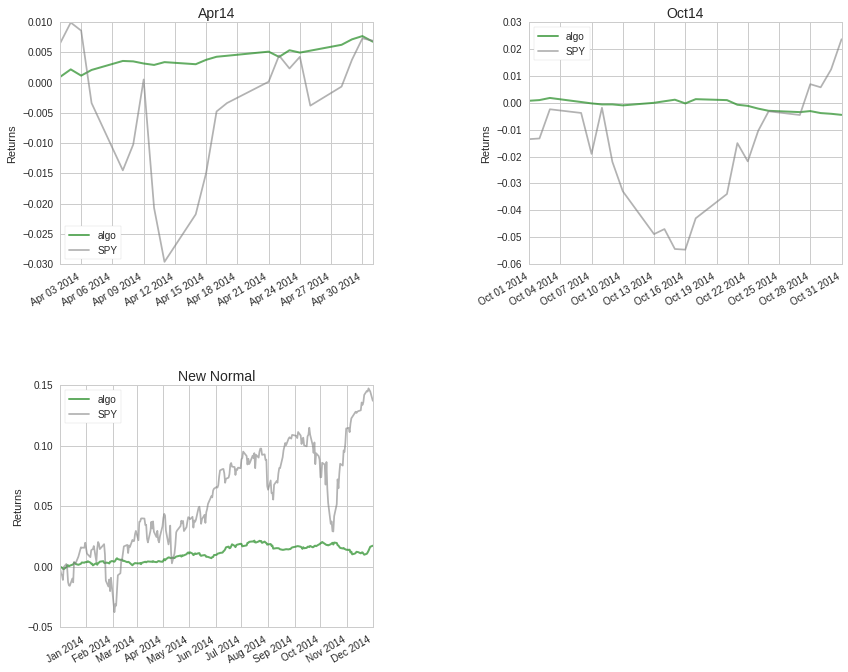

Top 10 long positions of all time,max
DNR-15789,0.60%
PPG-6116,0.60%
WPX-42251,0.60%
ATI-24840,0.59%
HP-3647,0.59%
CNX-24758,0.59%
INTC-3951,0.59%
TRIP-42230,0.59%
AET-168,0.59%
CIM-35081,0.59%


Top 10 short positions of all time,max
THC-5343,-0.45%
SHLD-26169,-0.45%
BBY-754,-0.45%
SPLS-7061,-0.44%
WTW-23269,-0.44%
GME-23438,-0.44%
CPB-1795,-0.44%
PFE-5923,-0.44%
T-6653,-0.44%
MAT-4668,-0.44%


Top 10 positions of all time,max
DNR-15789,0.60%
PPG-6116,0.60%
WPX-42251,0.60%
ATI-24840,0.59%
HP-3647,0.59%
CNX-24758,0.59%
INTC-3951,0.59%
TRIP-42230,0.59%
AET-168,0.59%
CIM-35081,0.59%


All positions ever held,max
DNR-15789,0.60%
PPG-6116,0.60%
WPX-42251,0.60%
ATI-24840,0.59%
HP-3647,0.59%
CNX-24758,0.59%
INTC-3951,0.59%
TRIP-42230,0.59%
AET-168,0.59%
CIM-35081,0.59%


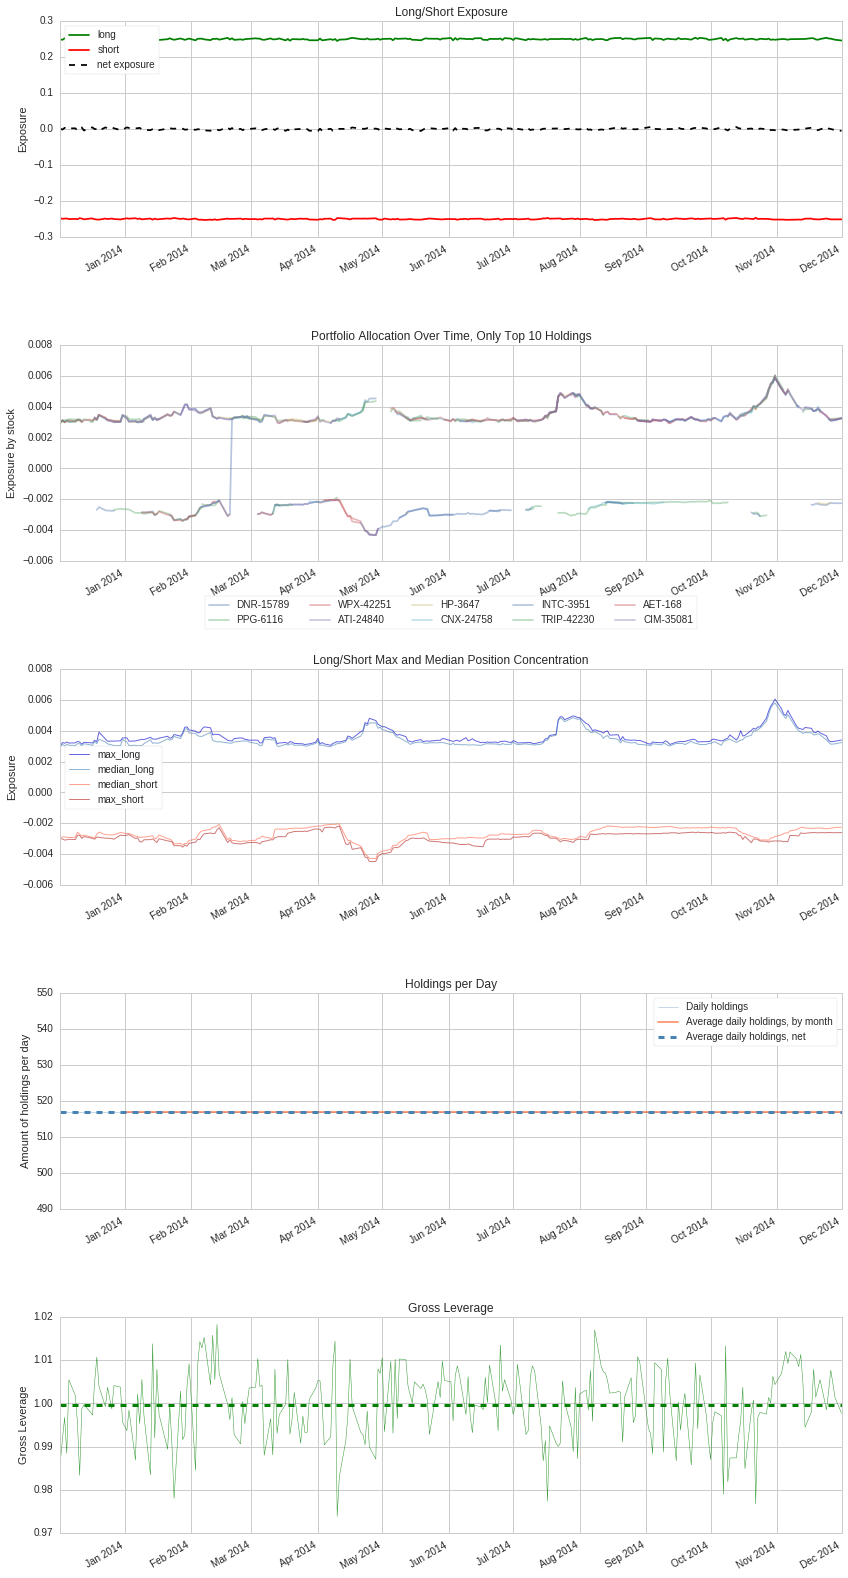

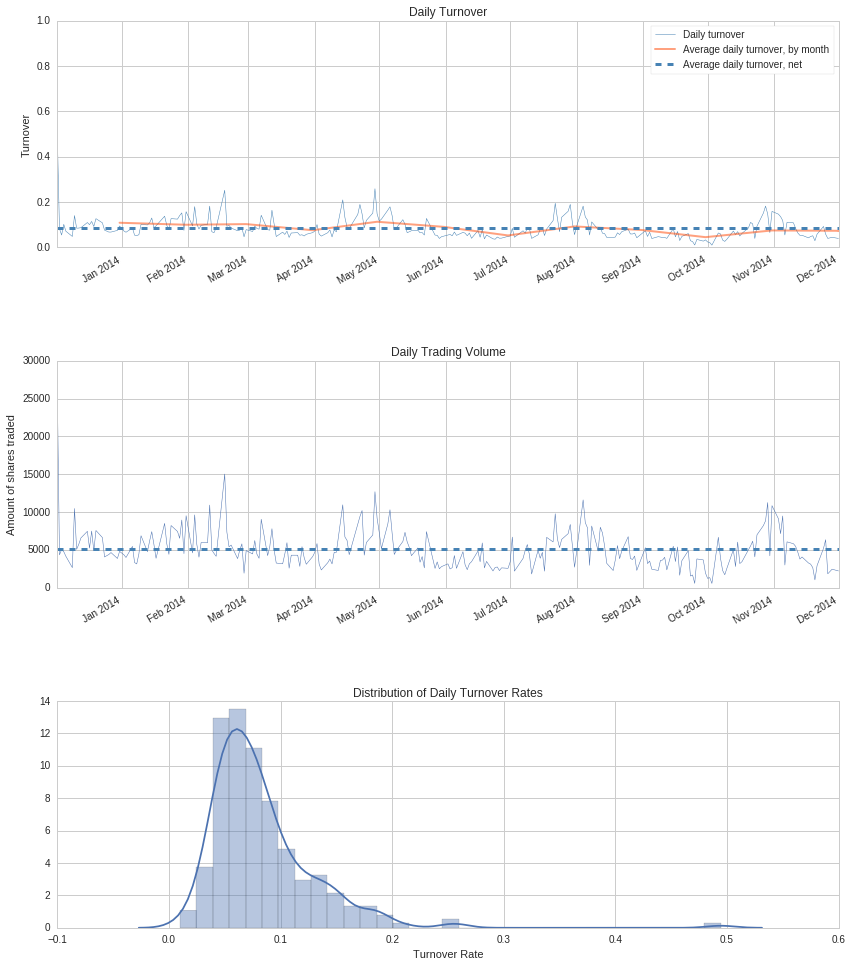

In [12]:
bt.create_full_tear_sheet()

And there you have it! Some key takeaways from the tearsheet:

- Long and short exposure are equal.
- Beta is 0.
- Holdings per day is > 500.
- Maximum position concentration is low (< 0.005).
- Trades daily.